# Test GP formulation as batch: Multi-Inputs, Single-Output 

## Description

This script trains a batch GP model of size (n_GP_models_in_batch), with a training input of size (n_GP_models_in_batch,n_offline_data,n_GP_inputs) and a training output of size (n_GP_models_in_batch,n_offline_data). 

The dimensions are based on the fact that the true function $g$ is a function of 3 inputs (n_GP_inputs=3) and a single output. Instead of training a single GP model, we train n_GP_models_in_batch models, all combined into a single batch. 

In principle, the different GP models along the dimension n_GP_models_in_batch could have different hyperparameters after the training/hyperparameter optimisation. Our setup requires however than all GP models have the same hyperparameters. After training, we therefore set the hyperparameter of the GP along the dimension n_GP_models_in_batch to be the same as the hyperparameters of the first GP along this dimension. 

The last part of the script tests the GP updates of a single GP along the n_GP_models_in_batch dimension.

## 1. Create training data and train model

In [1]:
import torch
import gpytorch
import math
from matplotlib import pyplot as plt

# Evalutate the true function g(x) = g(\phi,v1,v2)
def eval_g(phi, v1, v2):
    return v1 * (torch.cos(phi) - 1) - v2 * (torch.sin(phi) - phi)

# Generate training inputs according to a grid defined by the range of the arguments \phi,v1 and v2, and a number of data points along each dimension.
def generate_training_positions(phi_range, v1_range, v2_range, num_points):
    phi_points = torch.linspace(phi_range[0], phi_range[1], num_points)
    v1_points = torch.linspace(v1_range[0], v1_range[1], num_points)
    v2_points = torch.linspace(v2_range[0], v2_range[1], num_points)
    phi_grid, v1_grid, v2_grid = torch.meshgrid(phi_points, v1_points, v2_points, indexing='ij')
    X_train_offline = torch.stack([phi_grid.flatten(), v1_grid.flatten(), v2_grid.flatten()], dim=1)
    return X_train_offline

# Generate outputs of the function g for all n points in X_train (size of X_train is (n,n_g_inputs))
def generate_g_outputs(X_train, noise_size):
    n_train = X_train.shape[0]
    y_train = torch.zeros(n_train)
    for i in range(n_train):
        g_value = eval_g(X_train[i, 0], X_train[i, 1], X_train[i, 2])
        noise_value = (torch.rand(1) - 0.5) * noise_size
        y_train[i] = g_value + noise_value
    return y_train

# Generate X_train_offline
torch.manual_seed(0)
phi_range = (-torch.pi/12, torch.pi/12)
v1_range = (0.90,1.05)
v2_range = (0.90,1.05)
n_pts_per_dim = 9

# phi_range = (-torch.pi/12, torch.pi/12)
# v1_range = (0,0.6)
# v2_range = (-0.1,0.1)
# n_pts_per_dim = 9

X_train_offline = generate_training_positions(phi_range, v1_range, v2_range, n_pts_per_dim)
# X_train_offline = torch.cat((X_train_offline,X_train_offline),dim=0)
print(X_train_offline.shape)
n_offline_data = X_train_offline.shape[0]
n_GP_inputs = X_train_offline.shape[1]
noise_size = 0.001
y_train_offline = generate_g_outputs(X_train_offline, noise_size)

# Prepare for batch GP
n_gp_models_in_batch = 8
n_data_offline = X_train_offline.shape[0]
n_data_points_in_batch = 1000
X_train_batch = torch.zeros((n_gp_models_in_batch, n_data_points_in_batch, n_GP_inputs))
Y_train_batch = torch.full((n_gp_models_in_batch, n_data_points_in_batch), float('nan'))

# Copy the original data into the new tensors
X_train_batch[:, :n_data_offline, :] = X_train_offline.tile(n_gp_models_in_batch, 1, 1) # size of training data (X) for the batch is (n_gp_models_in_batch, n_data_points_in_batch, n_GP_inputs)
Y_train_batch[:, :n_data_offline] = y_train_offline.tile(n_gp_models_in_batch, 1)       # size of training data (Y) for the batch is (n_gp_models_in_batch, n_data_points_in_batch)
batch_shape = torch.Size([n_gp_models_in_batch])

# Define the GP model
class BatchGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, batch_shape):
        super(BatchGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=batch_shape)
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=batch_shape),
            batch_shape=batch_shape
        )


    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(batch_shape=batch_shape)  
gp_models_as_batch = BatchGPModel(X_train_batch, Y_train_batch, likelihood, batch_shape)

# Train the model
with gpytorch.settings.observation_nan_policy("mask"):
    
    # Training mode
    gp_models_as_batch.train()
    likelihood.train()

    optimizer = torch.optim.Adam(gp_models_as_batch.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_models_as_batch)

    training_iterations = 200
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = gp_models_as_batch(X_train_batch)
        loss = -mll(output, Y_train_batch).sum()  # Summing the losses across the batch dimensions
        loss.backward()
        print(f'Iter {i + 1}/{training_iterations} - Loss: {loss.item():.3f}')
        optimizer.step()

    # Set the model to evaluation mode
    gp_models_as_batch.eval()
    likelihood.eval()


torch.Size([729, 3])
Iter 1/200 - Loss: 4.348
Iter 2/200 - Loss: 4.133
Iter 3/200 - Loss: 3.914
Iter 4/200 - Loss: 3.691
Iter 5/200 - Loss: 3.463
Iter 6/200 - Loss: 3.230
Iter 7/200 - Loss: 2.994
Iter 8/200 - Loss: 2.753
Iter 9/200 - Loss: 2.508
Iter 10/200 - Loss: 2.259
Iter 11/200 - Loss: 2.006
Iter 12/200 - Loss: 1.749
Iter 13/200 - Loss: 1.489
Iter 14/200 - Loss: 1.225
Iter 15/200 - Loss: 0.958
Iter 16/200 - Loss: 0.687
Iter 17/200 - Loss: 0.414
Iter 18/200 - Loss: 0.137
Iter 19/200 - Loss: -0.142
Iter 20/200 - Loss: -0.423
Iter 21/200 - Loss: -0.707
Iter 22/200 - Loss: -0.993
Iter 23/200 - Loss: -1.281
Iter 24/200 - Loss: -1.571
Iter 25/200 - Loss: -1.863
Iter 26/200 - Loss: -2.157
Iter 27/200 - Loss: -2.451
Iter 28/200 - Loss: -2.748
Iter 29/200 - Loss: -3.045
Iter 30/200 - Loss: -3.343
Iter 31/200 - Loss: -3.642
Iter 32/200 - Loss: -3.942
Iter 33/200 - Loss: -4.243
Iter 34/200 - Loss: -4.544
Iter 35/200 - Loss: -4.846
Iter 36/200 - Loss: -5.148
Iter 37/200 - Loss: -5.450
Iter 38

### Check hyperparameters: they are probably slightly different for each GP models

In [2]:
# Check hyperparameters of the GP models
def print_hyperparameters(gp_model):
    for name, param in gp_model.named_parameters():
        print(f"{name}: {param.data}")

print("Hyperparameters of the GP models:")
print_hyperparameters(gp_models_as_batch)

# Check hyperparameters of the likelihood
print("\nHyperparameters of the likelihood:")
for name, param in likelihood.named_parameters():
    print(f"{name}: {param.data}")

Hyperparameters of the GP models:
likelihood.noise_covar.raw_noise: tensor([[-11.9466],
        [-11.9466],
        [-11.9466],
        [-11.9466],
        [-11.9466],
        [-11.9466],
        [-11.9466],
        [-11.9466]])
mean_module.raw_constant: tensor([-0.1413, -0.1413, -0.1413, -0.1412, -0.1413, -0.1413, -0.1413, -0.1412])
covar_module.raw_outputscale: tensor([-4.3332, -4.3330, -4.3330, -4.3333, -4.3332, -4.3330, -4.3330, -4.3333])
covar_module.base_kernel.raw_lengthscale: tensor([[[0.0346]],

        [[0.0346]],

        [[0.0346]],

        [[0.0345]],

        [[0.0346]],

        [[0.0346]],

        [[0.0346]],

        [[0.0345]]])

Hyperparameters of the likelihood:
noise_covar.raw_noise: tensor([[-11.9466],
        [-11.9466],
        [-11.9466],
        [-11.9466],
        [-11.9466],
        [-11.9466],
        [-11.9466],
        [-11.9466]])


### Set the same hyperparameters across the different GP models

In [3]:
# Function to set hyperparameters of all batch dimensions to be the same as the first batch dimension
def set_hyperparameters_to_first_dimension(model, likelihood):
    with torch.no_grad():
        # Mean parameter
        model.mean_module.raw_constant.copy_(model.mean_module.raw_constant[0].expand_as(model.mean_module.raw_constant))

        # Covariance parameters
        model.covar_module.raw_outputscale.copy_(model.covar_module.raw_outputscale[0].expand_as(model.covar_module.raw_outputscale))
        model.covar_module.base_kernel.raw_lengthscale.copy_(model.covar_module.base_kernel.raw_lengthscale[0].expand_as(model.covar_module.base_kernel.raw_lengthscale))

        # Noise parameter
        likelihood.noise_covar.raw_noise.copy_(likelihood.noise_covar.raw_noise[0].expand_as(likelihood.noise_covar.raw_noise))

# Set hyperparameters
set_hyperparameters_to_first_dimension(gp_models_as_batch, likelihood)

### Check the hyperparameters again: there are all the same as needed

In [4]:
# Check hyperparameters of the GP models
def print_hyperparameters(gp_model):
    for name, param in gp_model.named_parameters():
        print(f"{name}: {param.data}")

print("Hyperparameters of the GP models:")
print_hyperparameters(gp_models_as_batch)

# Check hyperparameters of the likelihood
print("\nHyperparameters of the likelihood:")
for name, param in likelihood.named_parameters():
    print(f"{name}: {param.data}")

# Print the hyperparameters, not in there "raw" form
print("Mean constant:", gp_models_as_batch.mean_module.constant)
print("Output scale:", gp_models_as_batch.covar_module.outputscale)
print("Lengthscale:", gp_models_as_batch.covar_module.base_kernel.lengthscale)
print("Noise:", likelihood.noise_covar.noise)


Hyperparameters of the GP models:
likelihood.noise_covar.raw_noise: tensor([[-11.9466],
        [-11.9466],
        [-11.9466],
        [-11.9466],
        [-11.9466],
        [-11.9466],
        [-11.9466],
        [-11.9466]])
mean_module.raw_constant: tensor([-0.1413, -0.1413, -0.1413, -0.1413, -0.1413, -0.1413, -0.1413, -0.1413])
covar_module.raw_outputscale: tensor([-4.3332, -4.3332, -4.3332, -4.3332, -4.3332, -4.3332, -4.3332, -4.3332])
covar_module.base_kernel.raw_lengthscale: tensor([[[0.0346]],

        [[0.0346]],

        [[0.0346]],

        [[0.0346]],

        [[0.0346]],

        [[0.0346]],

        [[0.0346]],

        [[0.0346]]])

Hyperparameters of the likelihood:
noise_covar.raw_noise: tensor([[-11.9466],
        [-11.9466],
        [-11.9466],
        [-11.9466],
        [-11.9466],
        [-11.9466],
        [-11.9466],
        [-11.9466]])
Mean constant: Parameter containing:
tensor([-0.1413, -0.1413, -0.1413, -0.1413, -0.1413, -0.1413, -0.1413, -0.1413],
     

## 2. Plot the GP models

/mnt/c/users/mathi/documents/zo-gpmpc/env/lib/python3.10/site-packages/gpytorch/models/exact_prediction_strategies.py:278: RuntimeWarning: Observation NaN policy 'fill' makes the kernel matrix dense during exact prediction.
  warnings.warn(


tensor([[-0.2021, -0.1776],
        [-0.2021, -0.1776],
        [-0.2021, -0.1776],
        [-0.2021, -0.1776],
        [-0.2021, -0.1776],
        [-0.2021, -0.1776],
        [-0.2021, -0.1776],
        [-0.2021, -0.1776]], grad_fn=<ViewBackward0>)


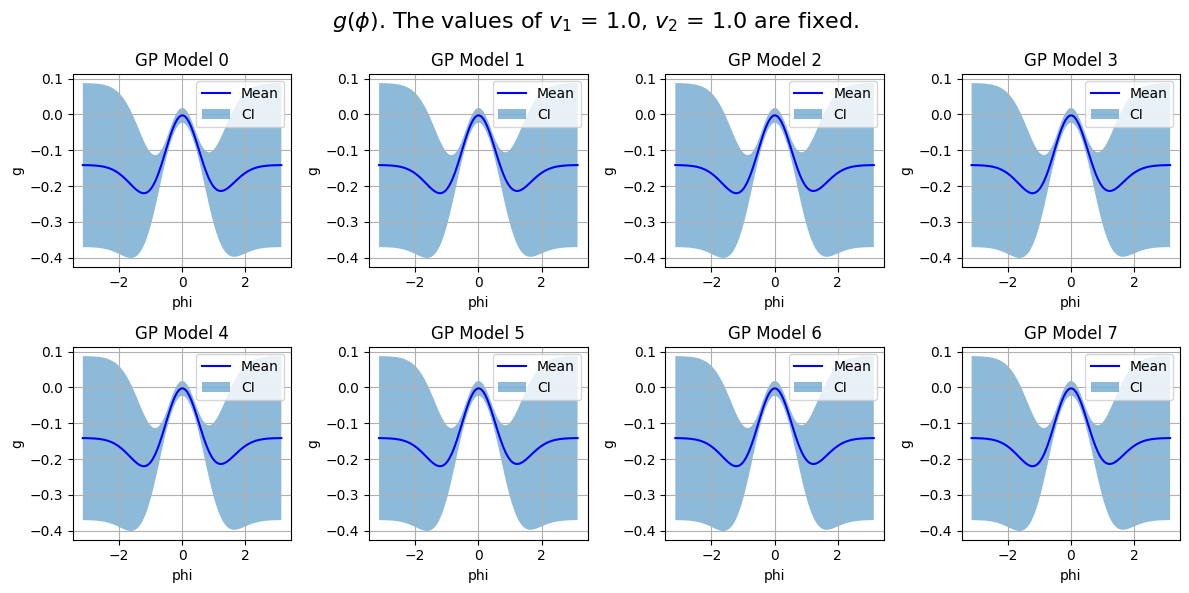

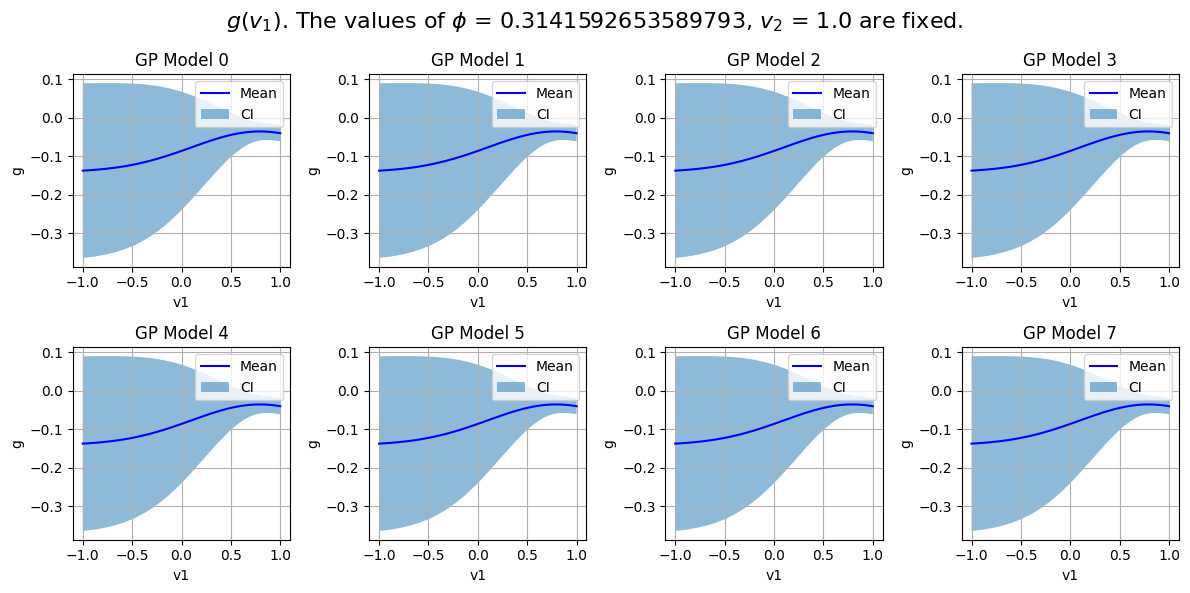

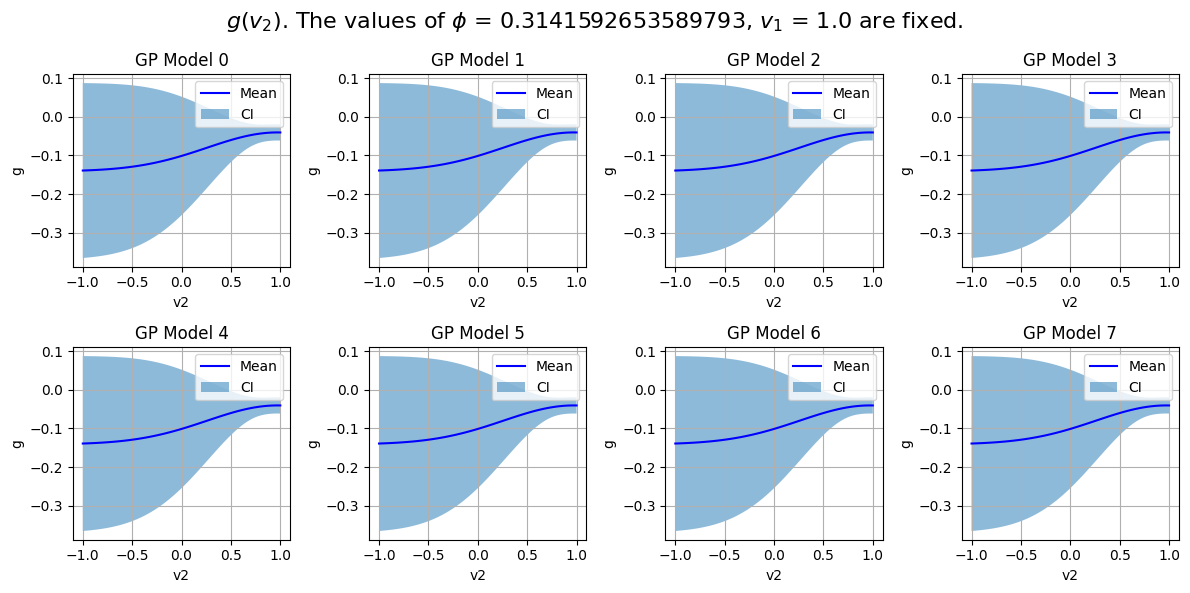

In [5]:
# Function to plot GP predictions
def plot_gp_models(model, likelihood, var_range, fixed_vals, var_name, n_gp_models, n_points=100):
    test_x = torch.zeros(n_points, 3)

    # Dictionary for LaTeX formatting
    var_latex_dict = {
        'phi': '$\phi$',
        'v1': '$v_1$',
        'v2': '$v_2$'
    }
    
    # Assign the range values to the appropriate variable
    if var_name == 'phi':
        test_x[:, 0] = torch.linspace(var_range[0], var_range[1], n_points)
        test_x[:, 1] = fixed_vals[0]  # v1
        test_x[:, 2] = fixed_vals[1]  # v2
    elif var_name == 'v1':
        test_x[:, 0] = fixed_vals[0]  # phi
        test_x[:, 1] = torch.linspace(var_range[0], var_range[1], n_points)
        test_x[:, 2] = fixed_vals[1]  # v2
    elif var_name == 'v2':
        test_x[:, 0] = fixed_vals[0]  # phi
        test_x[:, 1] = fixed_vals[1]  # v1
        test_x[:, 2] = torch.linspace(var_range[0], var_range[1], n_points)

    test_x = test_x.unsqueeze(0).repeat(n_gp_models, 1, 1)

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(test_x))

    mean = observed_pred.mean.numpy()
    lower, upper = observed_pred.confidence_region()
    lower = lower.numpy()
    upper = upper.numpy()

    # Determine the number of rows and columns for subplots
    n_rows = 2
    n_cols = math.ceil(n_gp_models/2)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6))
    if n_gp_models == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes.flat):
        ax.plot(test_x[0, :, 0].numpy() if var_name == 'phi' else (test_x[0, :, 1].numpy() if var_name == 'v1' else test_x[0, :, 2].numpy()), mean[i], 'b')
        ax.fill_between(test_x[0, :, 0].numpy() if var_name == 'phi' else (test_x[0, :, 1].numpy() if var_name == 'v1' else test_x[0, :, 2].numpy()), lower[i], upper[i], alpha=0.5)
        ax.set_title(f'GP Model {i}')
        ax.set_xlabel(var_name)
        ax.set_ylabel('g')
        ax.legend(['Mean', 'CI'])
        ax.grid()

    fixed_var_names = ['phi', 'v1', 'v2']
    fixed_var_names.remove(var_name)
    fixed_vals_str = ", ".join([f"{var_latex_dict[fixed_var_names[i]]} = {fixed_vals[i]}" for i in range(2)])
    g_dep_str = f"{var_latex_dict[var_name]}"

    fig.suptitle(f"$g(${g_dep_str}$)$. The values of {fixed_vals_str} are fixed.", fontsize=16)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the title

    
    plt.tight_layout()
    plt.show()

# Define which range/point combination to plot
phi_range = (-torch.pi , torch.pi)
v1_range = (-1., 1.)
v2_range = (-1., 1.)
fixed_phi = torch.pi/10
fixed_v1 = 1.0
fixed_v2 = 1.0



with gpytorch.settings.observation_nan_policy("fill"):

    # Print a single test
    print(gp_models_as_batch(torch.tensor([[1.5,1.0,1.0],[1.8,1.0,1.0]])).mean)

    # Plot GP models with varied phi, fixed v1, and fixed v2
    plot_gp_models(gp_models_as_batch, likelihood, phi_range, (fixed_v1, fixed_v2), 'phi', n_gp_models_in_batch)

    # Plot GP models with varied v1, fixed phi, and fixed v2
    plot_gp_models(gp_models_as_batch, likelihood, v1_range, (fixed_phi, fixed_v2), 'v1', n_gp_models_in_batch)

    # Plot GP models with varied v2, fixed phi, and fixed v1
    plot_gp_models(gp_models_as_batch, likelihood, v2_range, (fixed_phi, fixed_v1), 'v2', n_gp_models_in_batch)


## 3. Update the last GP model in the batch

In [6]:
X_update = torch.tensor([[2.0,1.0,1.0],
                         [2.05,1.0,1.0],
                         [2.0,1.0,1.05],
                         [1.95,1.0,1.0]])
Y_update = generate_g_outputs(X_update, noise_size)
n_update_data_points = X_update.shape[0]

X_train_batch[-1, :n_offline_data+n_update_data_points, :] = torch.cat((X_update,X_train_offline))
Y_train_batch[-1, :n_offline_data+n_update_data_points] = torch.cat((Y_update, y_train_offline))

with gpytorch.settings.observation_nan_policy("fill"):
    gp_models_as_batch.set_train_data(inputs=X_train_batch, targets=Y_train_batch)

## 4. Plot the updated batch

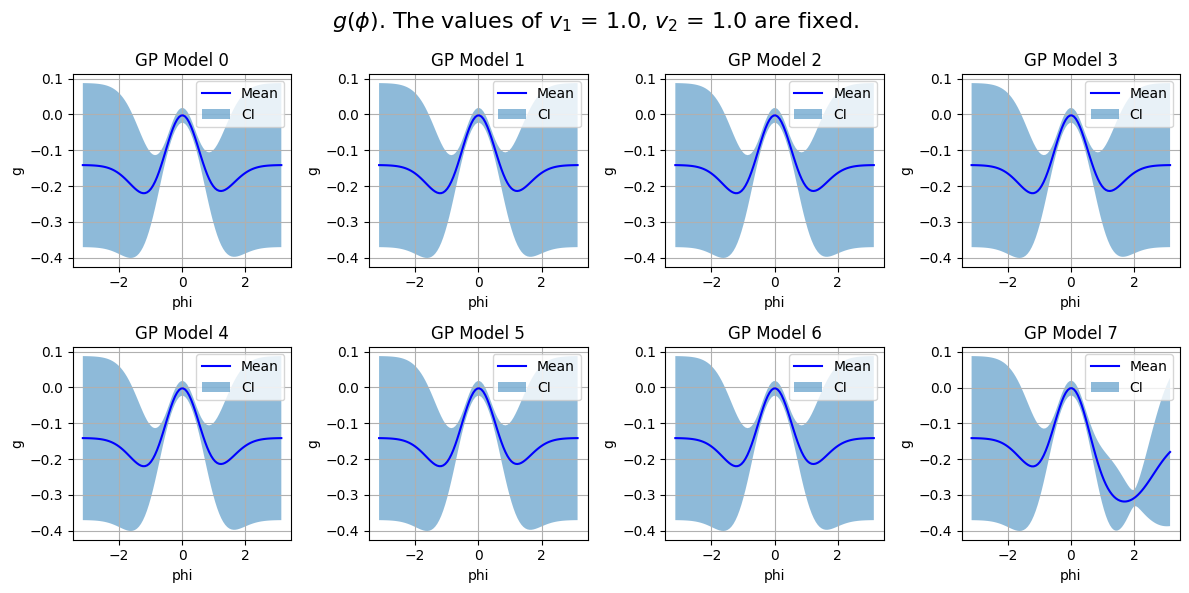

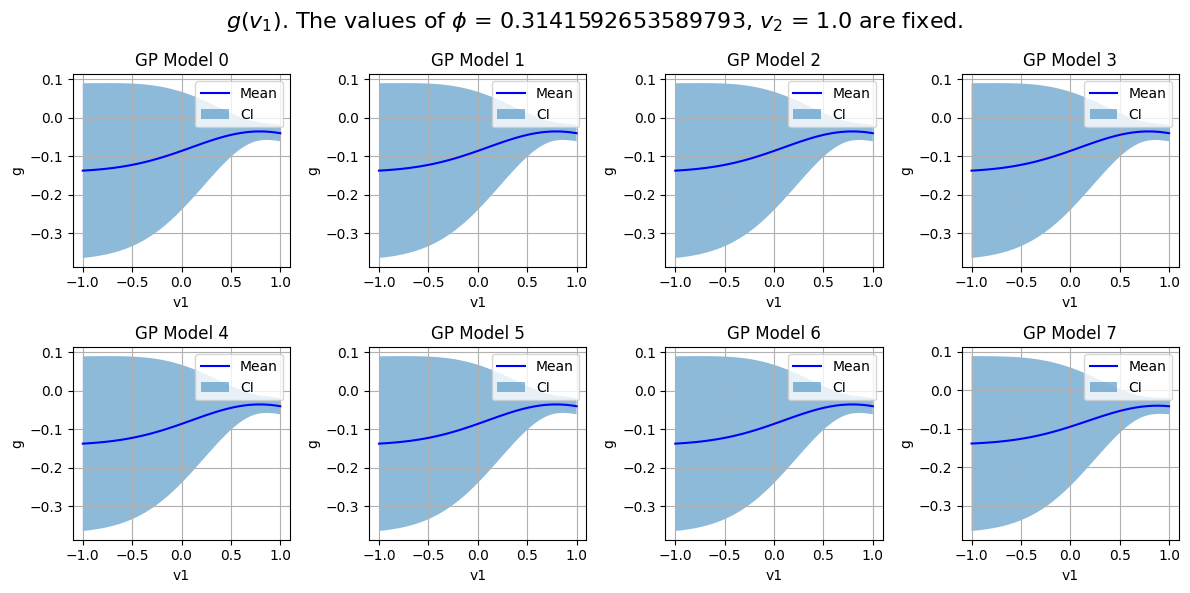

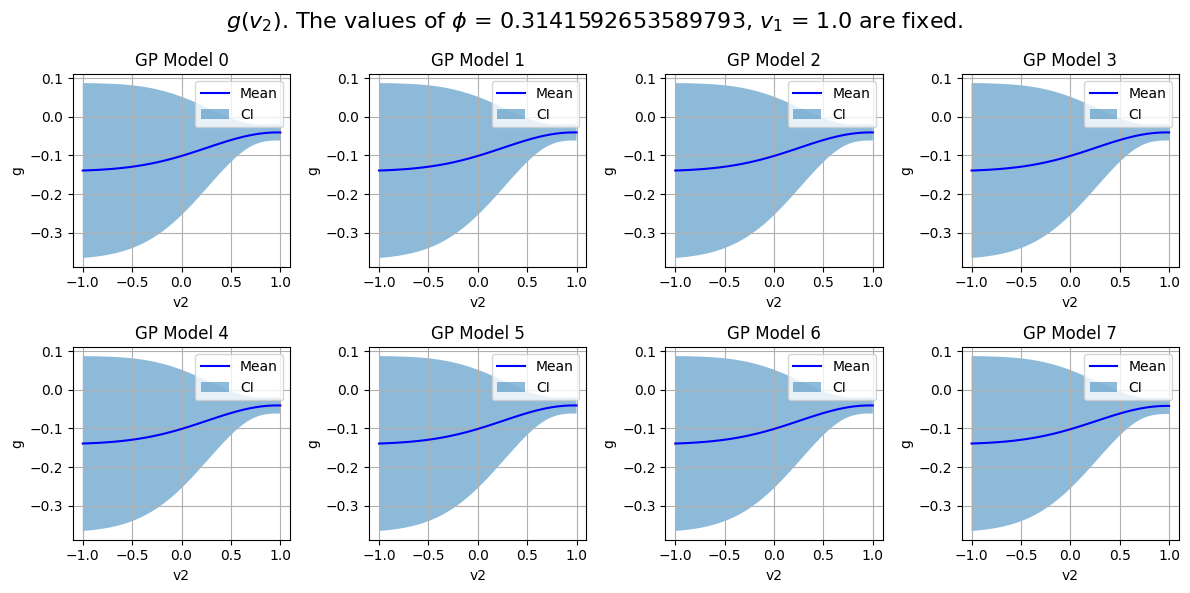

In [7]:
with gpytorch.settings.observation_nan_policy("fill"):
    # Plot GP models with varied phi, fixed v1, and fixed v2
    plot_gp_models(gp_models_as_batch, likelihood, phi_range, (fixed_v1, fixed_v2), 'phi', n_gp_models_in_batch)

    # Plot GP models with varied v1, fixed phi, and fixed v2
    plot_gp_models(gp_models_as_batch, likelihood, v1_range, (fixed_phi, fixed_v2), 'v1', n_gp_models_in_batch)

    # Plot GP models with varied v2, fixed phi, and fixed v1
    plot_gp_models(gp_models_as_batch, likelihood, v2_range, (fixed_phi, fixed_v1), 'v2', n_gp_models_in_batch)
